## Chapter 12: Discriminant Analysis and Other Linear Classification Models

In [1]:
from rpy2 import robjects
from rpy2.robjects.packages import importr, data
import os
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import OneHotEncoder

plt.rcParams['axes.grid'] = True
plt.gray()

%matplotlib inline
pd.set_option('mode.chained_assignment',None)

<Figure size 640x480 with 0 Axes>

In [2]:
base = importr('base')
set_seed = robjects.r("set.seed")
APM = importr('AppliedPredictiveModeling')
APMdatafolder = os.path.expanduser("~/Documents/dataset/AppliedPredictiveModeling/data")
print(os.path.isdir(APMdatafolder))
unimelbdatafolder = os.path.expanduser("~/Documents/dataset/unimelb")
os.path.isdir(unimelbdatafolder)

True


True

In [3]:
traindata_filename='unimelb_training.csv'
trainfile_path = os.path.join(unimelbdatafolder, traindata_filename)

### 1. Data clean

#### A few utility functions

In [4]:
def cleanRawData(raw0):
    raw = raw0.copy()
    raw['Sponsor.Code'] = raw['Sponsor.Code'].fillna('Unk')
    raw['Sponsor.Code'] = 'Sponsor'+raw['Sponsor.Code']

    raw['Grant.Category.Code'] = raw['Grant.Category.Code'].fillna('Unk')
    raw['Grant.Category.Code'] = 'GrantCat'+raw['Grant.Category.Code']

    raw['Contract.Value.Band...see.note.A'] = raw['Contract.Value.Band...see.note.A'].fillna('Unk')
    raw['Contract.Value.Band...see.note.A'] = 'ContractValueBand'+raw['Contract.Value.Band...see.note.A']

    raw['Role.1'] = raw['Role.1'].fillna('Unk')
    return raw
    
def getVerticalData(raw):
    namesPre = []
    int1to15 = [str(x) for x in range(1,16)]
    for x in raw.columns:
        if x[x.rfind(".")+1:] in int1to15:
            if x[:x.rfind(".")] not in namesPre:
                namesPre.append(x[:x.rfind(".")])
                
    tmp = []
    for i in range(1,16):
        tmpData = pd.DataFrame()
        tmpData['Grant.Application.ID'] = raw['Grant.Application.ID']
        for x in namesPre:
            if x+'.'+str(i) in raw.columns:
                tmpData[x] = raw[x+'.'+str(i)]
        tmp.append(tmpData)
    vertical = pd.concat(tmp)
    vertical = vertical[vertical['Role'].notnull()]
    return vertical

def cleanVerticalData(v0):
    v = v0.copy()
    v.loc[v['Country.of.Birth'].notnull(),'Country.of.Birth'] = \
        v[v['Country.of.Birth'].notnull()]['Country.of.Birth'].apply(lambda x: x.replace(" ",""))
    
    v['Home.Language'] = v['Home.Language'].apply(lambda x: 'OtherLang' if x=='Other' else x)
    v['Dept.No.'] = v['Dept.No.'].apply(lambda x: 'Dept'+str(int(x)) if pd.notna(x) else 'DeptNA')
    v['Faculty.No.'] = v['Faculty.No.'].apply(lambda x: 'Faculty'+str(int(x)) if pd.notna(x) else 'FacultyNA')
    
    v['RFCD.Code'] = v['RFCD.Code'].apply(lambda x: 'RFCD'+str(int(x)) if pd.notna(x) else 'RFCDNA')
    v['RFCD.Code'] = v['RFCD.Code'].apply(lambda x: 'RFCDNA' if x in ['RFCD0','RFCD999999'] else x)
    v.loc[v['RFCD.Code'].isin(['RFCDNA']),'RFCD.Percentage'] = None
    
    v['SEO.Code'] = v['SEO.Code'].apply(lambda x: 'SEO'+str(int(x)) if pd.notna(x) else 'SEONA')
    v['SEO.Code'] = v['SEO.Code'].apply(lambda x: 'SEONA' if x in ['SEO0','SEO999999'] else x)
    v.loc[v['SEO.Code'].isin(['SEONA']),'SEO.Percentage'] = None
    
    colName = 'No..of.Years.in.Uni.at.Time.of.Grant'
    v[colName] = v[colName].map({'>=0 to 5':'Duration0to5',
                                 '>5 to 10':'Duration5to10',
                                 '>10 to 15':'Duration10to15',
                                 'more than 15':'DurationGT15',
                                 'Less than 0':'DurationLT0'},
                           na_action='ignore')
    v[colName] = v[colName].fillna('DurationUnk')
    
    return v

def noZV(w): 
    dropColumns = []
    for c in w.columns:
        if len(w[c].drop_duplicates())==1:
            dropColumns.append(c)
    return w.drop(columns = dropColumns)
    
def getSummaryData(v):
    people, totalPub, investPub, investDuration, investFaculty, investDept, investGrants, \
        investPhD, investLang, investCountry, investDOB, investCount, grantData, SEOcount, RFCDcount \
        = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(),\
        pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(),\
        pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    
    allID = v[['Grant.Application.ID']].drop_duplicates().sort_values('Grant.Application.ID')
    
    shortNames = {"EXT_CHIEF_INVESTIGATOR":"ECI", "STUD_CHIEF_INVESTIGATOR":"SCI", "CHIEF_INVESTIGATOR":"CI",\
                 "DELEGATED_RESEARCHER":"DR", "EXTERNAL_ADVISOR":"EA", "HONVISIT":"HV",\
                 "PRINCIPAL_SUPERVISOR":"PS", "STUDRES":"SR", "Unk":"UNK", "":""}
    
    # calculate the number of people per Grant application
    w = v.groupby('Grant.Application.ID').agg(numPeople = ('Grant.Application.ID','count')).reset_index()
    people = noZV(allID.merge(w, on = ['Grant.Application.ID'], how = 'left'))
    
    # calculate the number of people per role
    pt = v[['Grant.Application.ID','Role']].groupby(['Grant.Application.ID', 'Role']).\
        agg(num = ('Role','count')).reset_index().\
        pivot(index = 'Grant.Application.ID',columns = 'Role').reset_index()
    newcolname = [x[0]+shortNames[x[1]] for x in pt.columns]
    pt.columns = newcolname
    pt = pt.fillna(0)
    investCount = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))
    
    # for each role, calculate the frequency of people in each age group
    x = v[['Grant.Application.ID','Role','Year.of.Birth']].\
        groupby(['Grant.Application.ID','Role','Year.of.Birth']).\
        agg(num = ('Grant.Application.ID','count')).reset_index()
    x = x.sort_values(['Year.of.Birth','Role'])
    x['roleC'] = x['Role'].map(shortNames,na_action = 'ignore')+"."+x['Year.of.Birth'].astype(int).astype(str)
    pt = x.pivot(index = 'Grant.Application.ID',columns = 'roleC',values = 'num').fillna(0).reset_index()
    pt.columns.names = [None]
    investDOB = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))
    
    # for each role, calculate the frequency of people from each country
    x = v[['Grant.Application.ID','Role','Country.of.Birth']].\
        groupby(['Grant.Application.ID','Role','Country.of.Birth']).\
        agg(num = ('Grant.Application.ID','count')).reset_index()
    x = x.sort_values(['Country.of.Birth','Role'])
    x['roleC'] = x['Role'].map(shortNames,na_action = 'ignore')+"."+x['Country.of.Birth']
    pt = x.pivot(index = 'Grant.Application.ID',columns = 'roleC',values = 'num').fillna(0).reset_index()
    pt.columns.names = [None]
    investCountry = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))
    
    # for each role, calculate the frenquency of people for each language
    x = v[['Grant.Application.ID','Role','Home.Language']].\
        groupby(['Grant.Application.ID','Role','Home.Language']).\
        agg(num = ('Grant.Application.ID','count')).reset_index()
    x = x.sort_values(['Home.Language','Role'])
    x['roleC'] = x['Role'].map(shortNames,na_action = 'ignore')+"."+x['Home.Language']
    pt = x.pivot(index = 'Grant.Application.ID',columns = 'roleC',values = 'num').fillna(0).reset_index()
    pt.columns.names = [None]
    investLang = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left').fillna(0))
    
    # for each role, determine who has a Ph.D
    x = v[['Grant.Application.ID','Role','With.PHD']].\
        groupby(['Grant.Application.ID','Role','With.PHD']).\
        agg(num = ('Grant.Application.ID','count')).reset_index()
    x = x.sort_values(['With.PHD','Role'])    
    x['roleC'] = x['Role'].map(shortNames,na_action = 'ignore')+'.PhD'
    pt = x.pivot(index = 'Grant.Application.ID',columns = 'roleC',values = 'num').fillna(0).reset_index()
    pt.columns.names = [None]
    for x in ['EA.PhD','SCI.PhD','UNK.PhD']:
        pt[x]=0
    investPhD = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))
    
    # for each role, calculate the number of successful and unsuccessful grants
    x = v[['Grant.Application.ID','Role','Number.of.Successful.Grant']].\
        groupby(['Grant.Application.ID','Role']).\
        agg(num = ('Number.of.Successful.Grant','sum')).reset_index()
    x = x.sort_values(['Role'])
    x['roleC'] = 'Success.'+x['Role'].map(shortNames,na_action = 'ignore')
    
    y = v[['Grant.Application.ID','Role','Number.of.Unsuccessful.Grant']].\
        groupby(['Grant.Application.ID','Role']).\
        agg(num = ('Number.of.Unsuccessful.Grant','sum')).reset_index()
    y = y.sort_values(['Role'])
    y['roleC'] = 'Unsuccess.'+y['Role'].map(shortNames,na_action = 'ignore')
    pt = pd.concat([x,y]).pivot(index = 'Grant.Application.ID',columns = 'roleC',values = 'num').fillna(0).reset_index()
    pt.columns.names = [None]
    investGrants = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))
    
    # Create variables for each role/department combination
    x = v[['Grant.Application.ID','Role','Dept.No.']].\
        groupby(['Grant.Application.ID','Role','Dept.No.']).\
        agg(num = ('Grant.Application.ID','count')).reset_index()
    x = x.sort_values(['Dept.No.','Role'])
    x['roleC'] = x['Role'].map(shortNames,na_action = 'ignore')+"."+x['Dept.No.']
    pt = x.pivot(index = 'Grant.Application.ID',columns = 'roleC',values = 'num').fillna(0).reset_index()
    pt.columns.names = [None]
    pt = pt[[x for x in pt.columns if 'DeptNA' not in x]]
    investDept = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))
    
    # Create variables for each role/faculty
    x = v[['Grant.Application.ID','Role','Faculty.No.']].\
        groupby(['Grant.Application.ID','Role','Faculty.No.']).\
        agg(num = ('Grant.Application.ID','count')).reset_index()
    x = x.sort_values(['Faculty.No.','Role'])
    x['roleC'] = x['Role'].map(shortNames,na_action = 'ignore')+"."+x['Faculty.No.']
    pt = x.pivot(index = 'Grant.Application.ID',columns = 'roleC',values = 'num').fillna(0).reset_index()
    pt.columns.names = [None]    
    pt = pt[[x for x in pt.columns if 'NA' not in x]]
    investFaculty = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))
    
    # Create dummy variables for each tenure length
    x = v[['Grant.Application.ID','No..of.Years.in.Uni.at.Time.of.Grant']].\
        groupby(['Grant.Application.ID','No..of.Years.in.Uni.at.Time.of.Grant']).\
        agg(num = ('Grant.Application.ID','count')).reset_index()
    pt = x.pivot(index = 'Grant.Application.ID', columns = 'No..of.Years.in.Uni.at.Time.of.Grant', values = 'num').fillna(0)
    pt.columns.names = [None]
    investDuration = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))
    
    # Create variables for the number of publications per journal type. 
    # Note that we also compute the total number, 
    # which should be removed for models that cannot deal with such a linear dependency
    x = v[['Grant.Application.ID','A.','A','B','C']].\
    groupby('Grant.Application.ID').\
    agg(AstarTotal = ('A.','sum'), ATotal=('A','sum'),BTotal = ('B', 'sum'), CTotal = ('C','sum')).reset_index().fillna(0)
    x['allPub'] = x['AstarTotal']+x['ATotal']+x['BTotal']+x['CTotal']
    totalPub = x
    
    # Create variables for the number of publications per journal type per role.
    x = v[['Grant.Application.ID','Role','A.','A','B','C']].rename(columns={'A.':'Astar'}).\
        groupby(['Grant.Application.ID','Role']).\
        agg({'Astar':'sum','A':'sum', 'B':'sum','C':'sum'}).reset_index()
    pt = x.pivot(index='Grant.Application.ID', columns = 'Role', values = ['Astar','A','B','C']).fillna(0)
    newColNames = [x[0]+'.'+shortNames[x[1]] for x in pt.columns]
    pt.columns = newColNames
    pt = pt.reset_index()
    investPub = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))
    
    # Create variables for each RFCD code
    x = v[['Grant.Application.ID','RFCD.Code']].\
        groupby(['Grant.Application.ID','RFCD.Code']).\
        agg(num = ('Grant.Application.ID','count')).reset_index()
    pt = x.pivot(index='Grant.Application.ID', columns = 'RFCD.Code',values = 'num').reset_index().drop(columns = ['RFCDNA']).fillna(0)
    pt.columns.names=[None]
    RFCDcount = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))

    # Create variables for each SEO code
    x = v[['Grant.Application.ID','SEO.Code']].\
        groupby(['Grant.Application.ID','SEO.Code']).\
        agg(num = ('Grant.Application.ID','count')).reset_index()
    pt = x.pivot(index='Grant.Application.ID', columns = 'SEO.Code',values = 'num').reset_index().fillna(0).drop(columns = ['SEONA'])
    pt.columns.names=[None]
    SEOcount = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))    
    
    # Create the grantData
    x = raw[["Sponsor.Code", "Contract.Value.Band...see.note.A", "Grant.Category.Code"]]
    enc = OneHotEncoder(handle_unknown='ignore')

    startTime = raw['Start.date'].apply(lambda x : datetime.strptime(x,'%d/%m/%y'))
    startYear = startTime.apply(lambda x: x.year)

    mthabbre=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    wdayabbre = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    x['Month'] = startTime.apply(lambda x: mthabbre[x.month-1])
    x['Day'] = startTime.apply(lambda x: x.day)
    x['yDay'] = startTime.apply(lambda x: 1+(x- datetime.strptime('1/1/'+str(x.year),'%d/%m/%Y')).days)
    x['Weekday']=startTime.apply(lambda x: wdayabbre[x.dayofweek])

    y = enc.fit_transform(np.array(x[['Sponsor.Code', "Contract.Value.Band...see.note.A", "Grant.Category.Code",'Month','Weekday']]))
    y = pd.DataFrame(data = y.toarray(),columns = enc.get_feature_names_out())
    y = y.rename(columns = dict(zip(list(y.columns), [x[3:] for x in y.columns])))
    y['Day'] = x['Day']
    y['yDay'] = x['yDay']
    y['Grant.Application.ID'] = raw['Grant.Application.ID']
    y['Class'] = raw['Grant.Status'].map({0:'unsuccessful', 1:'successful'})
    y['is2008'] = startYear == 2008
    y.columns = [a.strip() for a in y.columns]
    grantData = noZV(y)
    
    # Merge all the predictors together, remove zero variance columns and merge in the outcome data
    summarized = investCount
    for x in [investDOB, investCountry, investLang, investPhD, investGrants, \
        investDept, investFaculty, investDuration, investPub, totalPub, people, RFCDcount, SEOcount, grantData]:
        summarized = summarized.merge(x, on = ['Grant.Application.ID'], how = 'left')
    
    return investCount, investDOB, investCountry, investLang, investPhD, investGrants, \
        investDept, investFaculty, investDuration, investPub, totalPub, people, RFCDcount, SEOcount, grantData, summarized

In [5]:
def checkVerticalData(v):
    vertical_filename='vertical.csv'
    vertical_path = os.path.join(unimelbdatafolder, vertical_filename)

    v0 = pd.read_csv(vertical_path)
    v0['RFCD.Code'] = v0['RFCD.Code'].fillna('RFCDNA')
    v0['SEO.Code'] = v0['SEO.Code'].fillna('SEONA')
    v0['Dept.No.'] = v0['Dept.No.'].fillna('DeptNA')
    v0['Faculty.No.'] = v0['Faculty.No.'].fillna('FacultyNA')

    v0s = v0.sort_values(['Grant.Application.ID','RFCD.Code']).reset_index(drop=True)
    vs = v.sort_values(['Grant.Application.ID','RFCD.Code']).reset_index(drop=True)
    return v0s.equals(vs)

def checkSummaryData(summary):
    s = summary[-1].copy()
    s.columns = [x.lower() for x in s.columns]
    s =s.drop(columns = ['grant.application.id'])
    if 'yday' in s.columns:
        s = s.drop(columns=['yday'])

    summary_filename='summarized.csv'
    summary_path = os.path.join(unimelbdatafolder, summary_filename)
    s0 = pd.read_csv(summary_path)
    s0.columns = [x.lower() for x in s0.columns]

    cm = s[list(s0.columns)]==(s0)
    diffcol = []
    for x in s.columns:
        if (len(cm[x].value_counts())!=1):
            diffcol.append(x)

    # Check columns with PhD information: differ by NaN values
    p = summary[4].copy()
    p.columns = [x.lower() for x in p.columns]

    PHD_filename='investPhD.csv'
    PHD_path = os.path.join(unimelbdatafolder, PHD_filename)

    p0 = pd.read_csv(PHD_path)
    p0.columns = [x.lower() for x in p0.columns]
    p0 = p0[list(p.columns)]

    p = p.fillna('Missing')
    p0 = p0.fillna('Missing')

    # Check country columns: fill nan by 0 in getSummaryData
    c = summary[2].copy()
    c.columns = [x.lower() for x in c.columns]
    for x in c.columns:
        c[x]=c[x].fillna(0).astype('int64')

    Country_filename='investCountry.csv'
    Country_path = os.path.join(unimelbdatafolder, Country_filename)

    c0 = pd.read_csv(Country_path)
    c0.columns = [x.lower() for x in c0.columns]
    c0 = c0[list(c.columns)]

    # Check DOB columns: fill nan by 0 in getSummaryData
    b = summary[1].copy()
    b.columns = [x.lower() for x in b.columns]
    for x in b.columns:
        b[x]=b[x].fillna(0).astype('int64')

    DOB_filename='investDOB.csv'
    DOB_path = os.path.join(unimelbdatafolder, DOB_filename)

    b0 = pd.read_csv(DOB_path)
    b0.columns = [x.lower() for x in b0.columns]
    b0 = b0[list(b.columns)]

    return "Columns in Country and Date.of.Birth needs to fill null values by 0", {'PhD':p0.equals(p), 'Country': c0.equals(c), 'Date.of.Birth':b0.equals(b)}, \
    [x for x in list(c.columns)+list(b.columns) if x.lower()!='grant.application.id']

In [17]:
def getTrainTestData(s):
    summarized = s.copy()
    col1 = [x for x in summarized.columns if x.lower() =='is2008'][0]
    col2 = [x for x in summarized.columns if x.lower() =='grant.application.id'][0]
    
    training = summarized[~summarized[col1]] # data not in 2008
    year2008= summarized[summarized[col1]] # data in 2008

    np.random.seed(552)
    inTrain = np.random.choice(year2008.index, size = 1557, replace = False) # add 1557 records into training

    training2 = year2008[year2008.index.isin(inTrain)]
    testing = year2008[~year2008.index.isin(inTrain)] # 518 records of year 2008 as testing
    training = pd.concat([training, training2])

    training = training.drop(columns = [col1,col2])
    testing = testing.drop(columns = [col1,col2])

    training = noZV(training)
    testing = testing[list(training.columns)]
    year2008 = year2008[list(training.columns)]
    return training, testing, year2008

In [7]:
def removeHighCorrColumns(XTrain, threshold = 0.99):
    corr_df = XTrain.corr().fillna(0)
    for i in range(len(corr_df)):
        corr_df.iloc[i,i] = 0
    abs_corr = np.abs(np.array(corr_df))
    columnnames = list(corr_df.columns)

    while abs_corr.max() > threshold:
        i, j = np.unravel_index(abs_corr.argmax(), abs_corr.shape)
        #print(i,j, abs_corr.max())
        if abs_corr[i,].mean()> abs_corr[j,].mean():
            k = i
        else:
            k = j
        columnnames.pop(k)
        abs_corr = np.delete(abs_corr, k, axis = 0)
        abs_corr = np.delete(abs_corr, k, axis = 1)
    return columnnames

def nearZeroVar(X, freqCut):
    columnnames = list(X.columns)
    percentUnique, freqRatio, zeroVar, nzv = [], [], [], []
    for c in columnnames:
        w = X[c]
        valcnt = w.value_counts().values
        percentUnique.append(100* len(valcnt)/valcnt.sum())
        zeroVar.append(True if len(valcnt)==1 else False)
        if len(valcnt)==1: 
            freqRatio.append(0)
        else:
            freqRatio.append(valcnt[0]/valcnt[1])
        nzv.append(freqRatio[-1]==0 or freqRatio[-1]>freqCut)
    df = pd.DataFrame({'col':columnnames, 'freqRatio':freqRatio, 'zeroVar':zeroVar,'nzv':nzv}).set_index('col')
    df.index.name = None
    return df

def getFullSetReducedSet(training):
    fullSet = [x for x in training.columns if x.lower()!='class']
    XTrain = training[fullSet]
    col1 = removeHighCorrColumns(XTrain)
    fullSet = col1

    isNZV = nearZeroVar(training[fullSet], int(len(training)/5))
    fullSet = list(isNZV[~isNZV['nzv']].index)

    reducedSet = list(isNZV[(~isNZV['nzv']) & (isNZV['freqRatio']<int(len(training)/50))].index)
    reducedSet = [x for x in reducedSet if x.lower() not in ['allpub','numpeople','mar','sun']]
    return fullSet, reducedSet

#### Read csv file and get summary data

In [8]:
raw = pd.read_csv(trainfile_path, low_memory=False)
raw = raw.drop(columns = ['Unnamed: 251'])
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Columns: 251 entries, Grant.Application.ID to C.15
dtypes: float64(179), int64(2), object(70)
memory usage: 16.7+ MB


In [10]:
raw = cleanRawData(raw)
vertical = cleanVerticalData((getVerticalData(raw)))

In [11]:
s = getSummaryData(vertical)
m, dic, l = checkSummaryData(s)

In [12]:
summarized = s[-1]
fillList = [x for x in summarized.columns if x.lower() in l]
summarized[fillList] = summarized[fillList].fillna(0)

In [14]:
summarized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8708 entries, 0 to 8707
Columns: 1916 entries, Grant.Application.ID to is2008
dtypes: bool(1), float64(1910), int64(4), object(1)
memory usage: 127.3+ MB


In [19]:
# year 2008 has 2075 records, pre 2008 has 6633 records
# Training : pre2008 data + 1557 records in year 2008
# Testing: 518 records in year 2008
training, testing, year2008Data = getTrainTestData(summarized)

In [20]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8190 entries, 0 to 8707
Columns: 1894 entries, numCI to Class
dtypes: float64(1890), int64(3), object(1)
memory usage: 118.4+ MB


In [187]:
'''
fullSet, reducedSet = getFullSetReducedSet(training)
pd.DataFrame({'colName':fullSet}).to_csv("./fullset.csv",index=False)
pd.DataFrame({'colName':reducedSet}).to_csv("./reducedset.csv",index=False)
'''

In [21]:
np.array(training).shape, np.array(testing).shape, np.array(year2008Data).shape

((8190, 1894), (518, 1894), (2075, 1894))

In [22]:
pre2008Data = training[~training.index.isin(year2008Data.index)]
test2008 = testing

In [23]:
allData=training
holdout2008 = testing

In [24]:
np.array(pre2008Data).shape, np.array(test2008).shape, np.array(allData).shape, np.array(holdout2008).shape

((6633, 1894), (518, 1894), (8190, 1894), (518, 1894))

In [288]:
fullSet = pd.read_csv("./fullset.csv")['colName'].to_list()
reducedSet = pd.read_csv("./reducedset.csv")['colName'].to_list()
if 'yDay' not in fullSet:
    fullSet.append('yDay')
if 'yDay' not in reducedSet:
    reducedSet.append('yDay')
reducedSet.remove('Day')
fullSet.remove('Day')

In [289]:
len(fullSet), len(reducedSet) #1070,  256 after adding yDay

(1069, 255)

### 2. Logistic Regression
{0:'unsuccessful', 1:'successful'}

In [125]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay

In [126]:
def modelPerf(model, X, y):
    y_true = y
    y_pred = model.predict(X)
    print(f"Report of {model.__class__.__name__}:")
    print(classification_report(y_true, y_pred, digits = 7))
    
    f = plt.figure(figsize=(10,4))
    ax1 = f.add_subplot(121)
    cmdisp = ConfusionMatrixDisplay(confusion_matrix(y_true,y_pred), display_labels=model.classes_)
    cmdisp.plot(ax = ax1)
    
    y_score = model.predict_proba(X)[:,1]
    roc_area = roc_auc_score(y_true, y_score)
    ax2 = f.add_subplot(122)
    roc_disp = RocCurveDisplay.from_estimator(model, X, y, ax = ax2)
    print(f"The area under the ROC curve is {roc_area}")

In [123]:
pre2008Data.head(10)

,numCI,numDR,numEA,numECI,numHV,numPS,numSR,numSCI,numUNK,CI.1900,...,Fri,Mon,Sat,Sun,Thu,Tue,Wed,Day,yDay,Class
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8,312,successful
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11,315,successful
2,3.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,14,318,successful
3,1.0,0.0,0.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,15,319,successful
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,16,320,unsuccessful
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,19,323,successful
6,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,19,323,unsuccessful
7,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,19,323,unsuccessful
8,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,19,323,successful
9,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,19,323,successful


In [164]:
onefeatName = 'yDay'
trainX_1feat = np.array(pre2008Data[onefeatName]).reshape(-1,1)
trainy_1feat = pre2008Data['Class'].apply(lambda x : 1 if x =='successful' else 0)
testX_1feat = np.array(test2008[onefeatName]).reshape(-1,1)
testy_1feat = test2008['Class'].apply(lambda x : 1 if x =='successful' else 0)

In [275]:
modelFit= linear_model.LogisticRegression()
modelFit.fit(trainX_1feat, trainy_1feat)

LogisticRegression()

In [276]:
lin_a = modelFit.coef_[0][0]
lin_b = modelFit.intercept_[0]

lin_a, lin_b

(-0.004238095577989463, 0.9193353121819308)

In [277]:
poly = PolynomialFeatures(degree = 2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(trainX_1feat)

daySquareModel = linear_model.LogisticRegression()
daySquareModel.fit(X_poly, trainy_1feat)

LogisticRegression()

Report of LogisticRegression:
              precision    recall  f1-score   support

           0  0.5891643 0.7900000 0.6749592      3400
           1  0.6557377 0.4206619 0.5125306      3233

    accuracy                      0.6099804      6633
   macro avg  0.6224510 0.6053310 0.5937449      6633
weighted avg  0.6216129 0.6099804 0.5957896      6633

The area under the ROC curve is 0.588622477756955


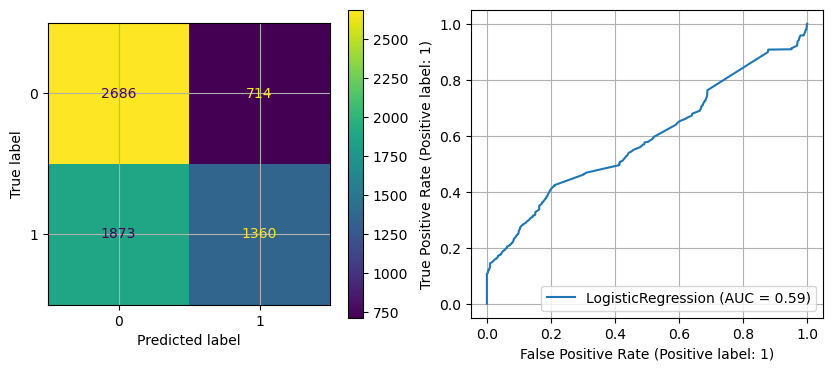

In [179]:
modelPerf(modelFit,trainX_1feat, trainy_1feat)

Report of LogisticRegression:
              precision    recall  f1-score   support

           0  0.5125886 1.0000000 0.6777634      3400
           1  0.0000000 0.0000000 0.0000000      3233

    accuracy                      0.5125886      6633
   macro avg  0.2562943 0.5000000 0.3388817      6633
weighted avg  0.2627470 0.5125886 0.3474138      6633

The area under the ROC curve is 0.588622477756955


/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


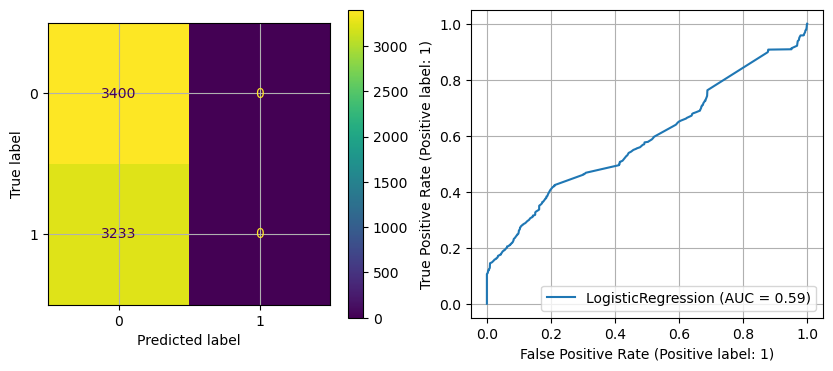

In [180]:
modelPerf(daySquareModel,X_poly,trainy_1feat)

In [238]:
df1=pd.DataFrame({'yDay':trainX_1feat.ravel(),'output':trainy_1feat})
df1['dayBin'] = pd.cut(df1.yDay, list(range(1,366,5)),right=False)
df2 = df1.groupby('dayBin').agg({'output':'mean'}).reset_index()
df2['leftPt'] = df2['dayBin'].apply(lambda x: x.left)

In [278]:
sqc1, sqc2 = daySquareModel.coef_[0]
sq_b = daySquareModel.intercept_[0]
print(sqc1, sqc2, sq_b)  
sq_b, sqc1, sqc2 = (1.881341, -0.018622,0.000038)

-1.081221761847889e-08 -2.782327943012534e-06 3.7455964688809855e-11


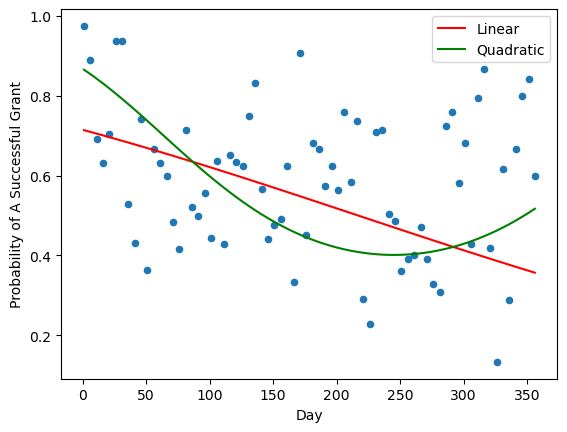

In [281]:
dx = np.linspace(1,356,72)
dy = 1/(1+np.exp(-(lin_b+lin_a*dx)))
dz = 1/(1+np.exp(-(sq_b +sqc1*dx +sqc2*dx*dx)))

ax1 = df2.plot.scatter(x = 'leftPt', y = 'output',grid = False, xlabel = 'Day', ylabel = 'Probability of A Successful Grant')
ax1.plot(dx,dy, c='red', label = 'Linear')
ax1.plot(dx,dz, c='green', label = 'Quadratic')
_ = ax1.legend()

In [309]:
trainX_reduced = pre2008Data[reducedSet]
trainX_reduced['yDay2'] = trainX_reduced['yDay']**2
trainy_reduced = pre2008Data['Class'].apply(lambda x : 1 if x =='successful' else 0)
testX_reduced = test2008[reducedSet]
testX_reduced['yDay2'] = testX_reduced['yDay']**2
testy_reduced = test2008['Class'].apply(lambda x : 1 if x =='successful' else 0)

indx = pre2008Data['CI.PhD'].notnull()
trainX_reduced = trainX_reduced[indx]
trainy_reduced = trainy_reduced[indx]

In [310]:
lrReduced= linear_model.LogisticRegression()
lrReduced.fit(trainX_reduced, trainy_reduced)

/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Report of LogisticRegression:
              precision    recall  f1-score   support

           0  0.7608696 0.7129323 0.7361213      2111
           1  0.7473947 0.7912621 0.7687031      2266

    accuracy                      0.7534841      4377
   macro avg  0.7541322 0.7520972 0.7524122      4377
weighted avg  0.7538936 0.7534841 0.7529891      4377

The area under the ROC curve is 0.7893221443763448


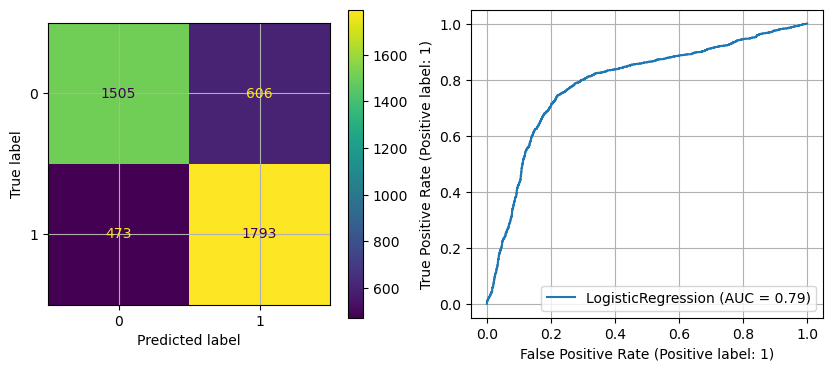

In [311]:
modelPerf(lrReduced, trainX_reduced, trainy_reduced)